In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt 

/Users/joaomata/Desktop/LBMP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing DepRoBERTa original

In [10]:
# Load the trasncripts of the 125 patients 
clean_summarized_df = pd.read_csv("/Users/joaomata/Desktop/LBMP/TextFeatures/CleanedSummarizedTranscriptions.tsv", sep='\t')
clean_summarized_df


,patient_id,original_transcript,PHQ_Score
0,302,"Okay, there you go. So you can just move arou...",4
1,303,"Okay, there you are. Wow. You won't see yours...",0
2,308,"Just takes a sec. Okay, perfect. So if we jus...",22
3,309,So we're just going to move around and make s...,15
4,314,There you are. Don't I look gorgeous? Let me ...,1
...,...,...,...
120,673,Okay. Now I'm going to bring her over to a hu...,13
121,677,"Okay, I'm going to bring up our Virgin Human....",12
122,680,"Okay, okay. Thank you. Yep. There she is. Whe...",22
123,684,go ahead and press this button. Some people t...,18


In [12]:
train_df = pd.read_csv("/Users/joaomata/Desktop/LBMP/TextFeatures/FilesForModel/train_ids.tsv", sep='\t')
test_df = pd.read_csv("/Users/joaomata/Desktop/LBMP/TextFeatures/FilesForModel/eval_ids.tsv", sep='\t')

print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)
print("train_dataset shape:", train_df.shape)
print("clean_summarized_df shape:", test_df.shape)


train_df shape: (100, 1)
test_df shape: (25, 1)
train_dataset shape: (100, 1)
clean_summarized_df shape: (25, 1)


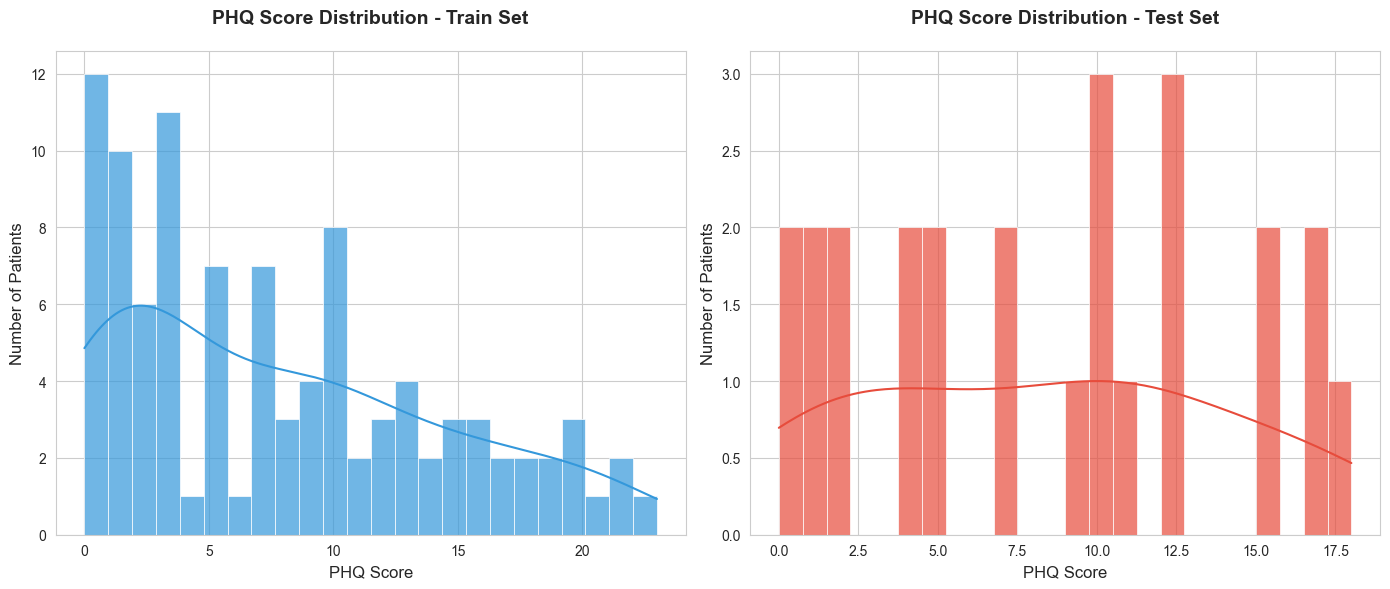

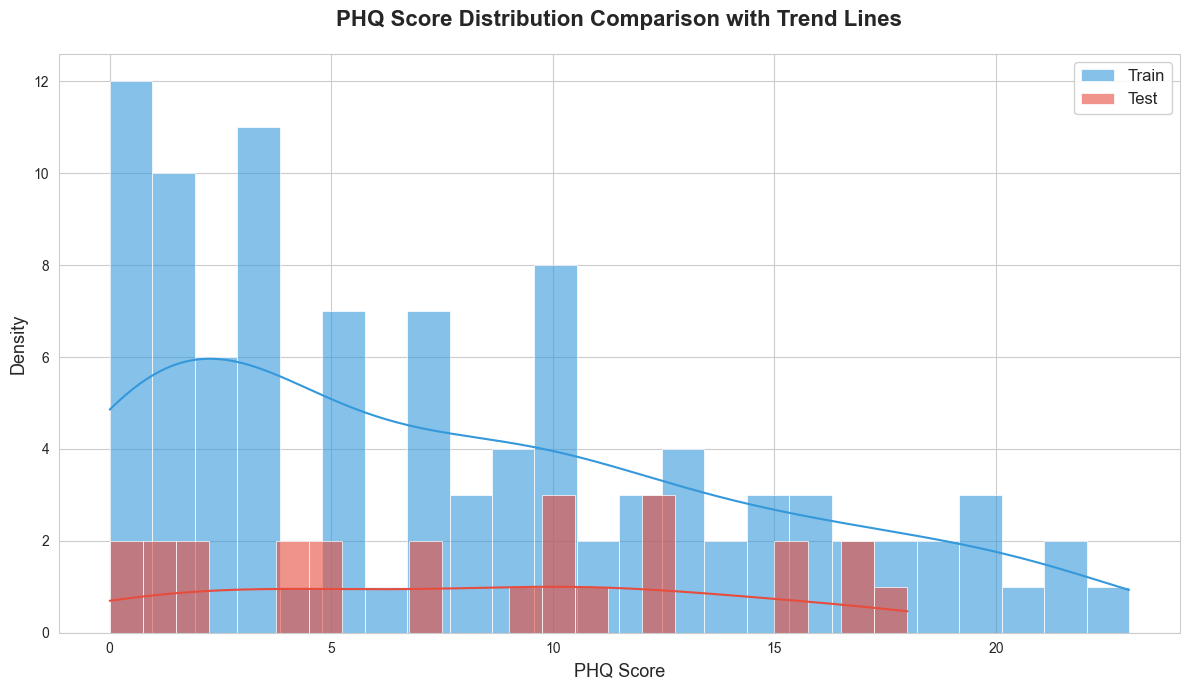

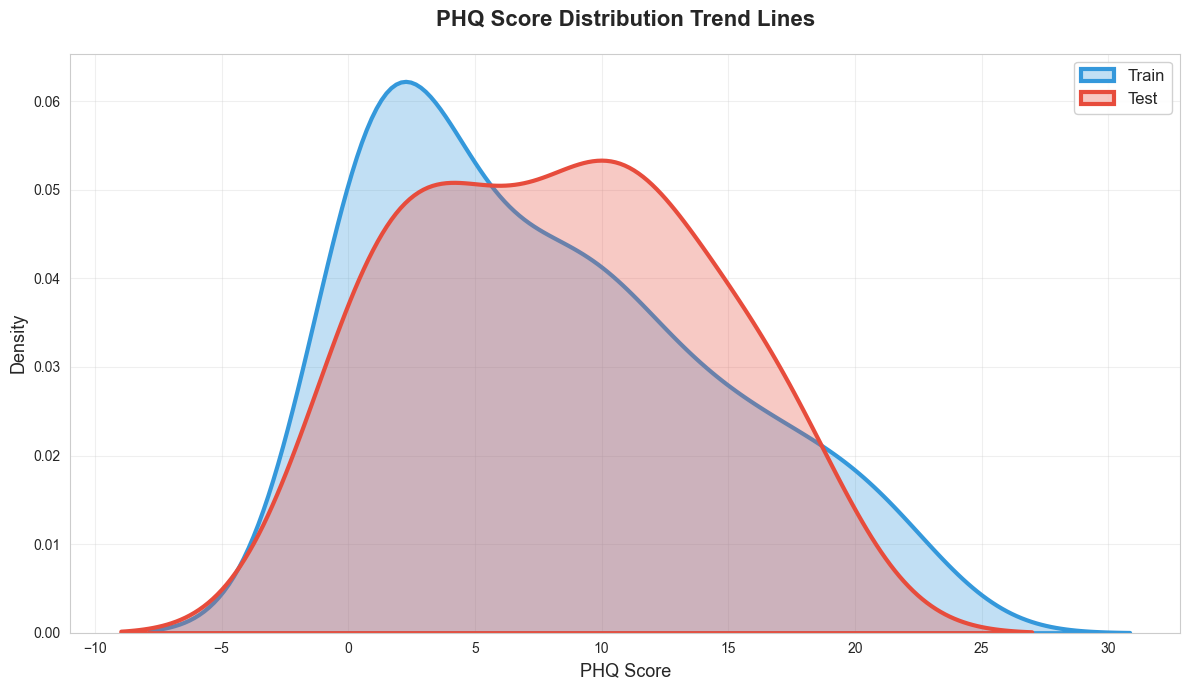


PHQ Score Statistics:
Train Set - Mean: 7.76, Std: 6.57
Test Set  - Mean: 8.24, Std: 5.70


In [23]:
# Merge train_df and test_df with clean_summarized_df to get PHQ_Score for each patient_id
train_with_scores = pd.merge(train_df, clean_summarized_df[['patient_id', 'PHQ_Score']], on='patient_id', how='left')
test_with_scores = pd.merge(test_df, clean_summarized_df[['patient_id', 'PHQ_Score']], on='patient_id', how='left')

# Set seaborn style for cleaner plots
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Train distribution with trend line
sns.histplot(data=train_with_scores, x='PHQ_Score', bins=24, 
             color='#3498db', alpha=0.7, edgecolor='white', linewidth=0.5, kde=True, ax=axes[0])
axes[0].set_title('PHQ Score Distribution - Train Set', fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('PHQ Score', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)

# Test distribution with trend line
sns.histplot(data=test_with_scores, x='PHQ_Score', bins=24, 
             color='#e74c3c', alpha=0.7, edgecolor='white', linewidth=0.5, kde=True, ax=axes[1])
axes[1].set_title('PHQ Score Distribution - Test Set', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('PHQ Score', fontsize=12)
axes[1].set_ylabel('Number of Patients', fontsize=12)

plt.tight_layout()
plt.show()

# Alternative: Single plot with overlapping distributions and trend lines
plt.figure(figsize=(12, 7))
sns.histplot(data=train_with_scores, x='PHQ_Score', bins=24, alpha=0.6, 
             color='#3498db', label='Train', edgecolor='white', linewidth=0.5, kde=True)
sns.histplot(data=test_with_scores, x='PHQ_Score', bins=24, alpha=0.6, 
             color='#e74c3c', label='Test', edgecolor='white', linewidth=0.5, kde=True)

plt.title('PHQ Score Distribution Comparison with Trend Lines', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('PHQ Score', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.show()

# Dedicated KDE plot for cleaner trend line visualization
plt.figure(figsize=(12, 7))
sns.kdeplot(data=train_with_scores, x='PHQ_Score', color='#3498db', 
            linewidth=3, label='Train', fill=True, alpha=0.3)
sns.kdeplot(data=test_with_scores, x='PHQ_Score', color='#e74c3c', 
            linewidth=3, label='Test', fill=True, alpha=0.3)

plt.title('PHQ Score Distribution Trend Lines', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('PHQ Score', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Bonus: Statistical summary
print("\nPHQ Score Statistics:")
print(f"Train Set - Mean: {train_with_scores['PHQ_Score'].mean():.2f}, Std: {train_with_scores['PHQ_Score'].std():.2f}")
print(f"Test Set  - Mean: {test_with_scores['PHQ_Score'].mean():.2f}, Std: {test_with_scores['PHQ_Score'].std():.2f}")



In [16]:
# Load original model 

tokenizer = AutoTokenizer.from_pretrained("rafalposwiata/deproberta-large-depression")
model = AutoModelForSequenceClassification.from_pretrained("rafalposwiata/deproberta-large-depression")

In [17]:

BATCH_SIZE = 8
LABEL_MAP = {0: "not depression", 1: "moderate", 2: "severe"}

# -------------- FUNCTION: PREDICTION ------------------
def predict_classes(model, tokenizer, texts, batch_size=8, max_len=512, label_map=None):
    model.eval()
    preds = []
    probs = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=max_len)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            batch_probs = torch.softmax(logits, dim=1).cpu().numpy()
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
            probs.extend(batch_probs)
    
    if label_map:
        pred_labels = [label_map[p] for p in preds]
    else:
        pred_labels = preds
    return pred_labels, probs

# Apply the prediction function to all the transcripts
deprobertaclassifier_preds, deprobertaclassifier_probs = predict_classes(
    model, tokenizer, clean_summarized_df['Cleaned_Summarized_Transcription'].tolist(),
    batch_size=BATCH_SIZE,
    label_map=LABEL_MAP
)
# Add predictions and probabilities to the DataFrame
clean_summarized_df['DeprobertaClassifier_Prediction'] = deprobertaclassifier_preds
clean_summarized_df['DeprobertaClassifier_Probabilities'] = deprobertaclassifier_probs
# Save the DataFrame with predictions and probabilities
clean_summarized_df.to_csv("/Users/joaomata/Desktop/LBMP/TextFeatures/CleanedSummarizedTranscriptions_with_predictions.tsv", sep='\t', index=False)


KeyError: 'Cleaned_Summarized_Transcription'

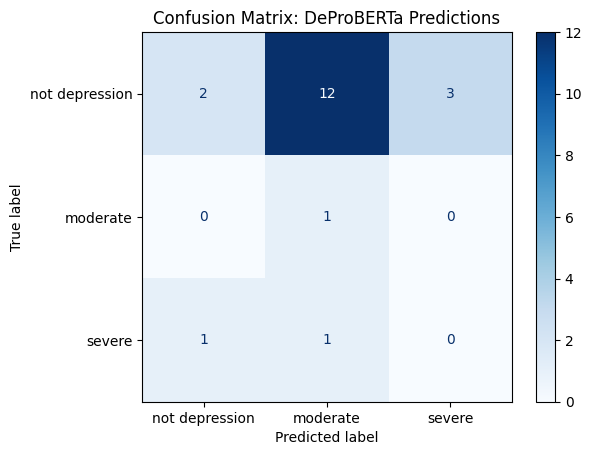

Accuracy: 0.1500
F1 Score: 0.1767
Recall: 0.1500
Precision: 0.5702


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get ground truth PHQ_Score for eval_dataset patients
filtered_gt = clean_summarized_df[clean_summarized_df["patient_id"].isin(eval_dataset["patient_id"])]
filtered_gt = filtered_gt.set_index("patient_id").loc[eval_dataset["patient_id"]].reset_index()

# Create confusion matrix
y_true = filtered_gt['PHQ_Score'].apply(lambda x: 'not depression' if x <= 7 else ('moderate' if x <= 13 else 'severe')).tolist()
y_pred = eval_dataset["deproberta_prediction"].tolist()

cm = confusion_matrix(y_true, y_pred, labels=['not depression', 'moderate', 'severe'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not depression', 'moderate', 'severe'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: DeProBERTa Predictions")
plt.show()

# Print metrics
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import precision_recall_fscore_support
accuracy = acc_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')

#print
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

## First attempt at finetuning

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define the path to your downloaded model directory
local_model_path = "./finetuned_models/checkpoint-40"  # Use consistent path

# Create a copy of eval_dataset
eval_dataset_ft = eval_dataset.copy()

# Load the tokenizer and model
tokenizer_ft = tokenizer # Reuse the original tokenizer
model_ft = AutoModelForSequenceClassification.from_pretrained(local_model_path)


In [75]:
# Assuming eval_dataset is a pandas DataFrame with a 'summary' column
summaries = eval_dataset["summary"].tolist()

# Predict
eval_preds, probs = predict_classes(model_ft, tokenizer_ft, summaries, batch_size=BATCH_SIZE, label_map=LABEL_MAP)

# Add predictions to dataset
eval_dataset_ft["deproberta_prediction"] = eval_preds

# Add probabilities to dataset
eval_dataset_ft["deproberta_prob"] = probs

# Display or export
display(eval_dataset_ft)  # or print(eval_dataset.head())

Predicting: 100%|██████████| 3/3 [00:33<00:00, 11.26s/it]


,patient_id,original_transcript,cleaned_transcript,summary,PHQ_Score,Dep_Severity,deproberta_prediction,deproberta_prob
83,457,"So when she's done, she's going to say goodby...","So when she's done, she's going to say goodbye...","I remember a period in my life, not that long ...",3,not depression,not depression,"[0.66038036, 0.21418399, 0.12543574]"
53,405,Okay. Thanks. Thanks. I'm going to go ahead a...,Okay. Thanks. I'm going to go ahead and move t...,Here’s a summary of my experience with depress...,17,severe,not depression,"[0.589972, 0.26718247, 0.14284554]"
70,432,Okay. Okay. Okay. Okay. Okay. Okay. Okay. Oka...,NaN,"I apologize, but the transcript of the intervi...",1,not depression,not depression,"[0.78169096, 0.09102801, 0.12728107]"
45,392,"Okay. Okay. Okay. Okay. Okay. Okay. Hi, I'm E...","Okay. Hi, I'm Ellie. Thanks for coming in toda...","I'm doing well today, and generally, I'd say I...",1,not depression,not depression,"[0.7319819, 0.16528799, 0.10273016]"
44,391,"Oh, I'm loose. Beep beep. Hi. So I'm going to...","Oh, I'm loose. Beep beep. Hi. So I'm going to ...",Here's a summary of my experience with depress...,9,moderate,not depression,"[0.6421207, 0.23113503, 0.12674421]"
39,379,"Okay. All right. Thank you. Hi, I'm Ellie. Th...","Okay. All right. Thank you. Hi, I'm Ellie. Tha...","As the interviewee, I can tell you that I have...",2,not depression,not depression,"[0.76755357, 0.13474135, 0.09770506]"
22,349,"Okay. All right, so now we'll start with the ...","Okay. All right, so now we'll start with the v...",Here's a summary of my experience with depress...,5,not depression,not depression,"[0.6197715, 0.24855754, 0.13167088]"
80,452,So she'll say bye and then you're going to pr...,So she'll say bye and then you're going to pre...,Here's a summary of my experience with depress...,1,not depression,not depression,"[0.6718106, 0.20789136, 0.12029799]"
10,324,"Okay, great. Everything looks good. I'm going...","Okay, great. Everything looks good. I'm going ...",Here's a summary of my experience with depress...,5,not depression,not depression,"[0.6782998, 0.19291516, 0.1287851]"
0,302,"Okay, there you go. So you can just move arou...","Okay, there you go. So you can just move aroun...",Here's a summary of my experience with depress...,4,not depression,not depression,"[0.64257884, 0.22703673, 0.13038445]"


['not depression', 'severe', 'not depression', 'not depression', 'moderate', 'not depression', 'not depression', 'not depression', 'not depression', 'not depression', 'severe', 'not depression', 'not depression', 'not depression', 'not depression', 'not depression', 'not depression', 'not depression', 'not depression', 'not depression']


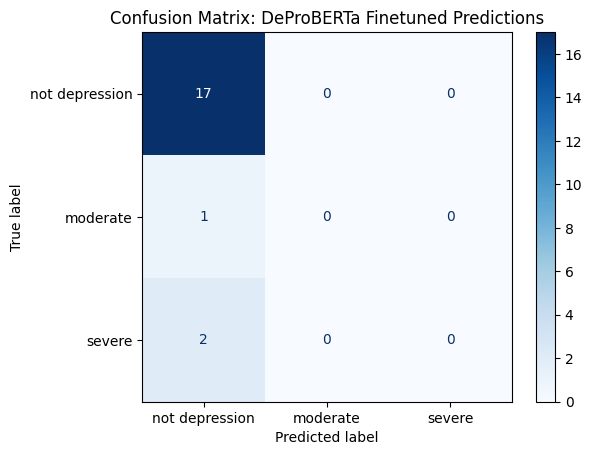

Accuracy: 0.8500
F1 Score: 0.7811
Recall: 0.8500
Precision: 0.7225


/Users/joaomata/Desktop/LBMP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get ground truth PHQ_Score for eval_dataset_ft patients
filtered_gt_ft = clean_summarized_df[clean_summarized_df["patient_id"].isin(eval_dataset_ft["patient_id"])]
filtered_gt_ft = filtered_gt_ft.set_index("patient_id").loc[eval_dataset_ft["patient_id"]].reset_index()
y_true_ft = filtered_gt_ft['PHQ_Score'].apply(lambda x: 'not depression' if x <= 7 else ('moderate' if x <= 13 else 'severe')).tolist()
print(y_true_ft)
y_pred_ft = eval_dataset_ft["deproberta_prediction"].tolist()

cm_ft = confusion_matrix(y_true_ft, y_pred_ft, labels=['not depression', 'moderate', 'severe'])
disp_ft = ConfusionMatrixDisplay(confusion_matrix=cm_ft, display_labels=['not depression', 'moderate', 'severe'])
disp_ft.plot(cmap='Blues')
plt.title("Confusion Matrix: DeProBERTa Finetuned Predictions")
plt.show()

from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import precision_recall_fscore_support
accuracy_ft = acc_score(y_true_ft, y_pred_ft)
precision_ft, recall_ft, f1_ft, _ = precision_recall_fscore_support(y_true_ft, y_pred_ft, average='weighted')

print(f"Accuracy: {accuracy_ft:.4f}")
print(f"F1 Score: {f1_ft:.4f}")
print(f"Recall: {recall_ft:.4f}")
print(f"Precision: {precision_ft:.4f}")


# TRYING UNDERSAMPLING

Balanced dataset shape: (48, 6)


/var/folders/cz/_btxbwrj7cx6d5v2vzg25g740000gn/T/ipykernel_23751/2246590141.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_class_count, random_state=42))


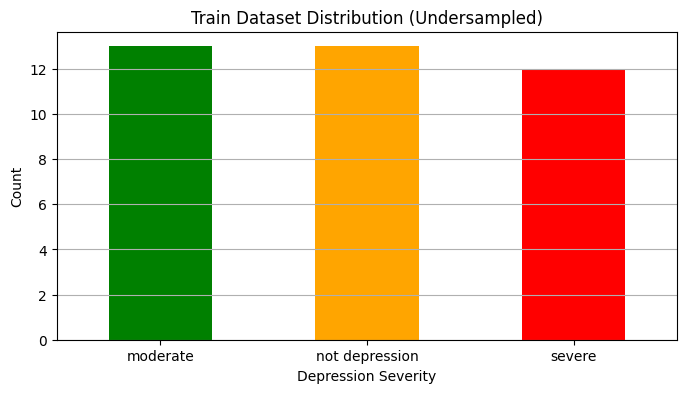

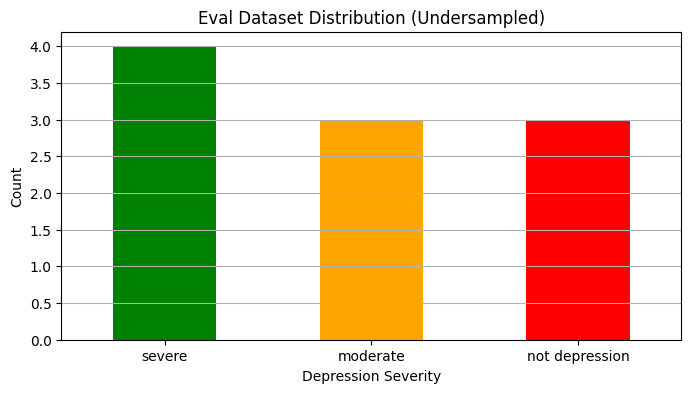

In [57]:
from sklearn.model_selection import train_test_split

# Step 1: Get minimum class count
min_class_count = clean_summarized_df['Dep_Severity'].value_counts().min()

# Step 2: Undersample each class
balanced_df = (
    clean_summarized_df.groupby('Dep_Severity')
    .apply(lambda x: x.sample(min_class_count, random_state=42))
    .reset_index(drop=True)
)
print("Balanced dataset shape:", balanced_df.shape)

# Step 3: Train-test split on balanced data
train_dataset_us, eval_dataset_us = train_test_split(
    balanced_df,
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['Dep_Severity']  # still stratify to keep balance in both sets
)
# Step 4: Plot new distribution
import matplotlib.pyplot as plt

# Plots
plt.figure(figsize=(8, 4))
train_dataset_us['Dep_Severity'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Train Dataset Distribution (Undersampled)')
plt.xlabel('Depression Severity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(8, 4))
eval_dataset_us['Dep_Severity'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Eval Dataset Distribution (Undersampled)')
plt.xlabel('Depression Severity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [58]:
train_dataset_us.to_csv("train_dataset_us.csv", index=False)

In [61]:

BATCH_SIZE = 8
LABEL_MAP = {0: "not depression", 1: "moderate", 2: "severe"}

# -------------- FUNCTION: PREDICTION ------------------
def predict_classes(model, tokenizer, texts, batch_size=8, max_len=512, label_map=None):
    model.eval()
    preds = []
    probs = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=max_len)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            batch_probs = torch.softmax(logits, dim=1).cpu().numpy()
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
            probs.extend(batch_probs)
    
    if label_map:
        pred_labels = [label_map[p] for p in preds]
    else:
        pred_labels = preds
    return pred_labels, probs

# -------------- EVALUATION SCRIPT ------------------
# Assuming `eval_dataset` is a pandas DataFrame with a 'summary' column
summaries = eval_dataset_us["summary"].tolist()

# Unpack the predictions and probabilities
preds, probs = predict_classes(model, tokenizer, summaries, batch_size=BATCH_SIZE, label_map=LABEL_MAP)

# Add predictions to dataset
eval_dataset_us["deproberta_prediction"] = preds
eval_dataset_us["deproberta_probabilities"] = probs

# Display or export
display(eval_dataset_us)  # or print(eval_dataset.head())

Predicting:   0%|          | 0/2 [00:00<?, ?it/s]

Predicting: 100%|██████████| 2/2 [00:17<00:00,  8.61s/it]


,patient_id,original_transcript,cleaned_transcript,summary,PHQ_Score,Dep_Severity,deproberta_prediction,deproberta_probabilities
12,376,"Nice, I have my hair. You see what you look l...","Here is the cleaned transcript:\n\nHi, I'm Ell...",Here's a summary of my experience with depress...,12,moderate,moderate,"[0.48118255, 0.49100062, 0.027816866]"
47,362,This is weird. Thank you. I'm not a therapist...,"This is weird. Thank you. I'm not a therapist,...","I apologize, but based on the transcript provi...",20,severe,severe,"[0.022143142, 0.15070459, 0.8271523]"
17,364,therapy like this instead of with a live huma...,Here is the cleaned transcript:\n\ntherapy lik...,"I generally feel pretty good these days, espec...",0,not depression,moderate,"[0.3687334, 0.45236632, 0.17890029]"
14,413,Thank you wanna hunch back in the chat? I jus...,Here is the cleaned transcript:\n\nI just want...,Here's a summary of my experience with depress...,10,moderate,moderate,"[0.12512156, 0.80536085, 0.06951764]"
10,466,"Do I talk? Okay. Okay. Okay. Okay. Yeah, is t...","Do I talk? Okay. Yeah, is that okay? It's bett...","I've been diagnosed with depression, first whe...",9,moderate,not depression,"[0.8329299, 0.15394069, 0.013129376]"
42,348,"Okay. Recording started. Beep, beep. So now I...","Okay. Recording started. Beep, beep. So now I'...",I was diagnosed with depression about a year a...,20,severe,not depression,"[0.4983192, 0.4596331, 0.0420477]"
43,367,"Are there any parameters? I mean, should I ju...","Are there any parameters? I mean, should I jus...",Here is a summary of my experience with depres...,19,severe,moderate,"[0.3131562, 0.64102936, 0.045814354]"
20,438,"Okay. So once again, when she says that, I'm ...",NaN,Here is a summary of my experience with depres...,2,not depression,moderate,"[0.07302316, 0.8870094, 0.039967492]"
41,483,"Okay, that looks good. Okay, when she says go...","Okay, that looks good. Okay, when she says goo...",Here’s a summary of my experience with depress...,15,severe,not depression,"[0.5965051, 0.36912033, 0.03437463]"
23,322,"Okay, this looks good. Great. Start this reco...","Okay, this looks good. Great. Start this recor...",Here is a summary of my experience with depres...,5,not depression,not depression,"[0.6632739, 0.31718162, 0.01954447]"


['not depression', 'severe', 'severe', 'not depression', 'severe', 'moderate', 'moderate', 'not depression', 'moderate', 'severe']
['moderate', 'severe', 'moderate', 'moderate', 'not depression', 'not depression', 'moderate', 'moderate', 'not depression', 'not depression']


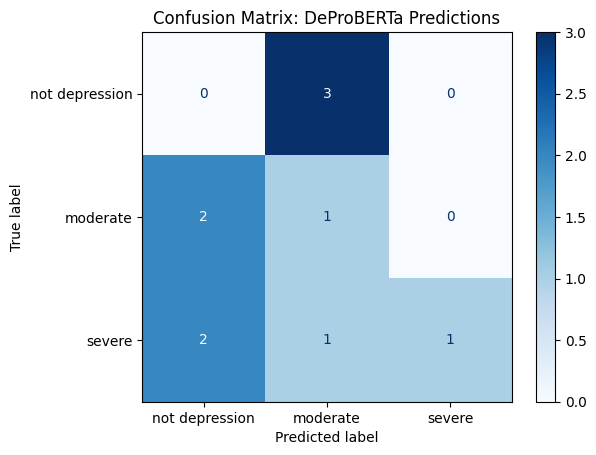

Accuracy: 0.2000
F1 Score: 0.2350
Recall: 0.2000
Precision: 0.4600


In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get ground truth PHQ_Score for eval_dataset patients
filtered_gt = clean_summarized_df[clean_summarized_df["patient_id"].isin(eval_dataset_us["patient_id"])]
#print(filtered_gt)

y_true = filtered_gt['Dep_Severity'].tolist()
print(y_true)

y_pred = eval_dataset_us["deproberta_prediction"].tolist()
print(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=['not depression', 'moderate', 'severe'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not depression', 'moderate', 'severe'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: DeProBERTa Predictions")
plt.show()

# Print metrics
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import precision_recall_fscore_support
accuracy = acc_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')

#print
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")